<a href="https://colab.research.google.com/github/jeanfcf/unemployment-forecast-uk/blob/arima-svr/ARIMA-SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ARIMA + SVR


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.utils import shuffle
from sklearn.metrics import r2_score,mean_squared_error
import sklearn.metrics as metrics
from sklearn import preprocessing, svm
import math
import matplotlib
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_absolute_error
from pandas import concat
from pandas import DataFrame
%load_ext rpy2.ipython
import warnings
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6 
from pmdarima.arima import auto_arima
warnings.filterwarnings("ignore")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
pip install pmdarima

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m')
df = pd.read_csv('/content/drive/MyDrive/Datasets/UK/UK-dataset.csv',parse_dates=['ANO'], index_col='ANO',date_parser=dateparse)
df = df.drop(['CASOS'], 1)
df = df.drop(['MORTES'], 1)
df = df.drop(['GDP'], 1)
df = df.drop(['LIBRA'], 1)
df = df.drop(['INFLACAO'], 1)
df = df.drop(['BANKRATE'], 1)
df.head()

,DESEMPREGO
ANO,
1997-01-01,7.5
1997-02-01,7.3
1997-03-01,7.2
1997-04-01,7.2
1997-05-01,7.2


In [ ]:
model = auto_arima(df,m=12,trace=3,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-574.014, Time=2.08 sec
First viable model found (-574.014)
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-507.221, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-548.851, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-532.859, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-506.542, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-571.169, Time=1.44 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-569.829, Time=1.32 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-569.198, Time=4.97 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-570.184, Time=4.39 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-565.781, Time=0.82 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-571.728, Time=3.44 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-569.887, Time=5.10 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-569.981, Time=5.57 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-576.04

In [ ]:
train = df.loc['1997-01-01':'2016-12-01']
test = df.loc['2017-01-01':]



In [ ]:
model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
forecast = model.predict(n_periods=51)

In [ ]:
future = pd.DataFrame(forecast,index=test.index,columns=['#DESEMPREGO'])

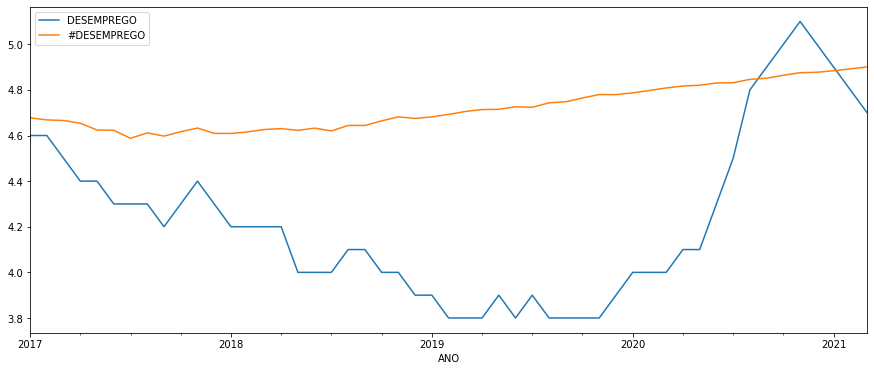

In [ ]:
pd.concat([test,future],axis=1).plot()

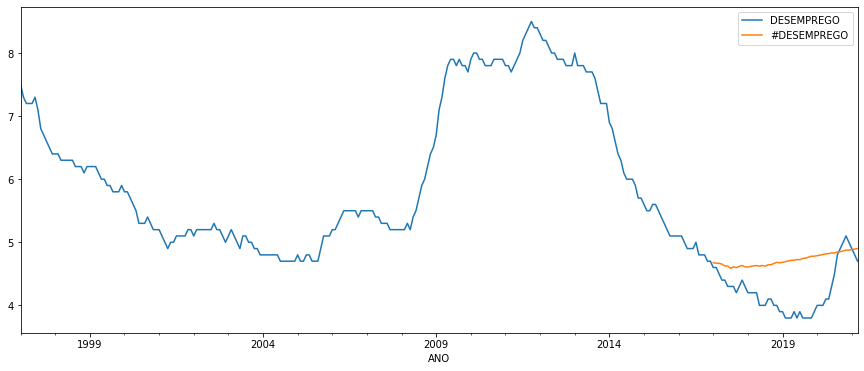

In [ ]:
pd.concat([df,future],axis=1).plot()

In [ ]:
residuo = pd.DataFrame(test.DESEMPREGO - future['#DESEMPREGO'] , columns=['residuos'])
residuo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2017-01-01 to 2021-03-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   residuos  51 non-null     float64
dtypes: float64(1)
memory usage: 3.3 KB


51
SVR Test MAE:0.013 MSE: 0.000 RMSE:0.015 MAPE:-0.004


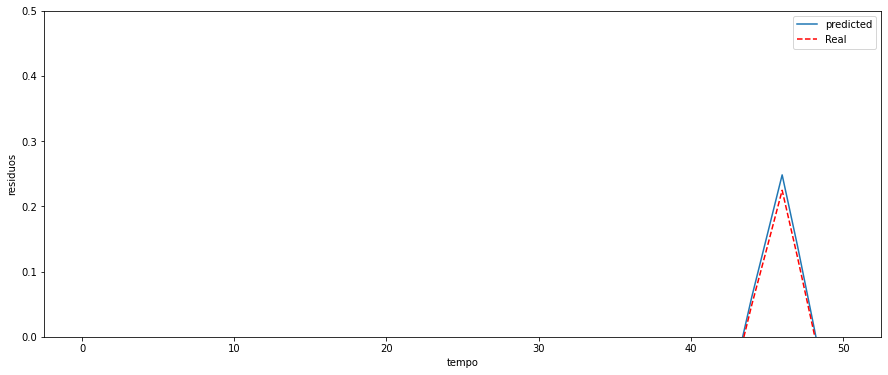

<Figure size 864x432 with 0 Axes>

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


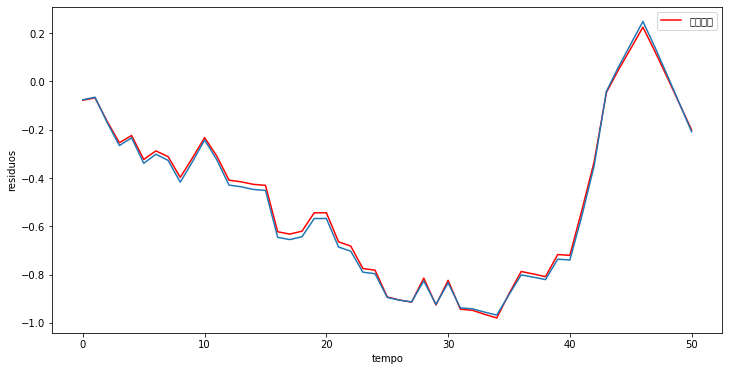

In [ ]:
import numpy
def mean_a_p_e(y_true, y_pred):
    sum = 0
    for i in range(len(y_true)):
        sum += math.fabs(y_pred[i] - y_true[i]) / y_true[i]
    return sum / len(y_true)


def parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


series = residuo
X = series.values
X = X.astype('float32')

train_start = 0
train_end = 40

test_start = 41
test_end = 51

svr_train, svr_test = X[train_start:train_end], X[test_start - 1:test_end - 1]
svr_real = numpy.array(X[train_start:test_end]).reshape(-1, 1)
svr_train = numpy.array(svr_train).reshape(-1, 1)

print(len(svr_real))
svr_test = numpy.array(svr_test).reshape(-1, 1)
param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(SVR(),param_grid)

grid.fit(svr_train[0:train_end - train_start - 1], svr_train[1:train_end - train_start])
p = grid.predict(svr_real)


mse = mean_squared_error(svr_real,p)
rmse = math.sqrt(mean_squared_error(svr_real,p))
mae = mean_absolute_error(svr_real,p)
mape = mean_a_p_e(svr_real,p)
print('SVR Test MAE:%.3f MSE: %.3f RMSE:%.3f MAPE:%.3f' % (mae, mse, rmse, mape))
plt.plot(p, '-', label="predicted")
plt.plot(svr_real, '--', color='red', label="Real")
plt.legend(loc='upper right')
plt.xlabel("tempo")
plt.ylabel("residuos")
plt.ylim(0, 0.5)
plt.figure(figsize=(12, 6))
plt.show()

datStart = 0

matplotlib.rcParams['font.family'] = 'SimHei'

plt.figure(figsize=(12, 6))
plt.plot(X, '-', color='r', label="真实流量")
plt.legend(loc='upper right')
plt.xlabel("tempo")
plt.ylabel("residuos")
plt.plot(p)
plt.show()



SVR Test MAE:0.013 MSE: 0.000 RMSE:0.015 MAPE:0.003


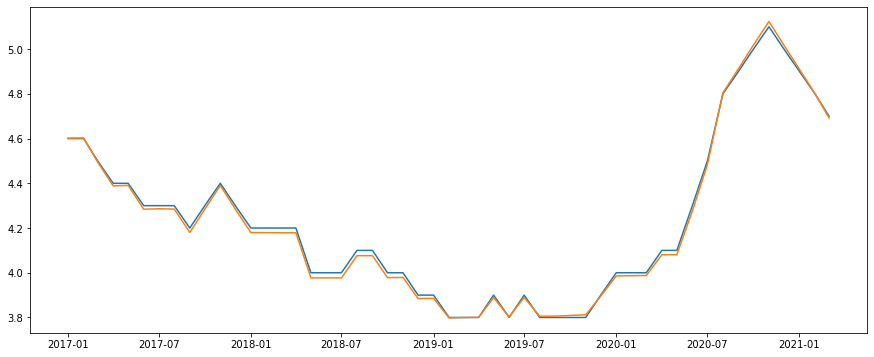

In [ ]:
preds_svr = future['#DESEMPREGO']+p

mse = mean_squared_error(test.DESEMPREGO,preds_svr)
rmse = math.sqrt(mean_squared_error(test.DESEMPREGO,preds_svr))
mae = mean_absolute_error(test.DESEMPREGO,preds_svr)
mape = mean_a_p_e(test.DESEMPREGO,preds_svr)
print('SVR Test MAE:%.3f MSE: %.3f RMSE:%.3f MAPE:%.3f' % (mae, mse, rmse, mape))
plt.plot(test.DESEMPREGO)
plt.plot(preds_svr)

In [ ]:
test.head()

,DESEMPREGO
ANO,
2017-01-01,4.6
2017-02-01,4.6
2017-03-01,4.5
2017-04-01,4.4
2017-05-01,4.4


In [ ]:
future.head()

,#DESEMPREGO
ANO,
2017-01-01,4.677848
2017-02-01,4.668275
2017-03-01,4.665840
2017-04-01,4.653969
2017-05-01,4.623984


In [ ]:
residuo.head()

,residuos
ANO,
2017-01-01,-0.077848
2017-02-01,-0.068275
2017-03-01,-0.165840
2017-04-01,-0.253969
2017-05-01,-0.223984


In [ ]:
preds_svr.head()

ANO
2017-01-01    4.601981
2017-02-01    4.602757
2017-03-01    4.494956
2017-04-01    4.388437
2017-05-01    4.390568
Name: #DESEMPREGO, dtype: float64

In [ ]:
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_Predicted - Y_actual)/Y_Predicted))*100
    return mape
mse = mean_squared_error(test.DESEMPREGO,preds_svr)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(test.DESEMPREGO,preds_svr)
mape = mape(test.DESEMPREGO,preds_svr)
r2 = metrics.r2_score(test.DESEMPREGO,preds_svr)
print("MAE", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R-Squared:", r2)

MAE 0.013452400069583564
MSE: 0.00023301794119547173
RMSE: 0.01526492519455866
MAPE: 0.3203879993119842
R-Squared: 0.9982435528167581
